In [20]:
%matplotlib inline

from pathlib import Path
import tempfile
import zipfile
import yaml
import importlib

import numpy as np
import matplotlib.pyplot as plt
import tifffile
import tensorflow as tf
from skimage import color
from skimage import transform

import quilt

# Configurations of the model
INPUT_NODE_IMAGE_NAME = "input_image"
INPUT_NODE_IMAGE_METADATA_NAME = "input_image_meta"
INPUT_NODE_ANCHORS_NAME = "input_anchors"
OUTPUT_NODE_NAMES = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois"]

def get_tensor(graph, name, suffix=":0"):
    return graph.get_tensor_by_name(f"{name}{suffix}")

Here we load the different graph paths and parameters from the ZIP archive or from the Quilt data package.

In [28]:
load_from_quilt = True

if load_from_quilt:    
    quilt_user = "hadim"
    quilt_model_name = "mask_rcnn_tf_model_in_vitro_microtubule"
    quilt_path = quilt_user + "/" + quilt_model_name
    quilt.install(quilt_path)

    quilt_model = importlib.import_module(f"quilt.data.{quilt_user}.{quilt_model_name}")

    tf_model_path = quilt_model.model()
    preprocessing_model_path = quilt_model.preprocessing_graph()
    postprocessing_model_path = quilt_model.postprocessing_graph()
    parameters_path = quilt_model.parameters()

else:
    root_dir = Path("/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/")
    saved_model_dir = root_dir / "saved_model"
    
    model_name = "microtubule_coco_512"
    zip_tf_model_path = saved_model_dir / f"tf_model_{model_name}.zip"

    temp_path = Path(tempfile.mkdtemp())
    with zipfile.ZipFile(zip_tf_model_path, "r") as z:
        z.extractall(temp_path)

    tf_model_path = temp_path /f"model.pb"
    preprocessing_model_path = temp_path / "preprocessing_graph.pb"
    postprocessing_model_path = temp_path / "postprocessing_graph.pb"
    parameters_path = temp_path / "parameters.yml"

hadim/mask_rcnn_tf_model_in_vitro_microtubule already installed.


In [29]:
# Load parameters
parameters = yaml.load(open(parameters_path))

BATCH_SIZE = 1

IMAGE_MIN_DIM = parameters["image_min_dimension"]
IMAGE_MAX_DIM = parameters["image_max_dimension"]
MIN_SCALE = parameters["minimum_scale"]
MEAN_PIXEL = parameters["mean_pixels"]
CLASS_IDS = parameters["class_ids"]
IMAGE_SHAPE = [IMAGE_MAX_DIM, IMAGE_MAX_DIM, 3]

BACKBONE_STRIDES = parameters["backbone_strides"]
RPN_ANCHOR_SCALES = parameters["rpn_anchor_scales"]
RPN_ANCHOR_RATIOS = parameters["rpn_anchor_ratios"]
RPN_ANCHOR_STRIDE = parameters["rpn_anchor_stride"]

# Load an image

(512, 512)

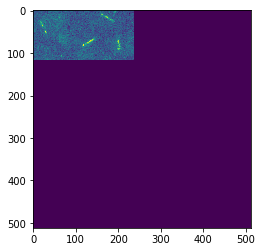

In [30]:
image_dir = Path("/home/hadim/Documents/Code/Postdoc/ij/testdata/")
image_path = image_dir / "fake-flat-corrected.tif"
image_path = image_dir / "7,5uM_emccd_lapse1-small-8bit-Single.tif"
#image_path = image_dir / "test-tracking-single.tif"
#image_path = image_dir / "test-tracking.tif"

original_images = tifffile.imread(str(image_path))
if len(original_images.shape) == 2:
    original_images = np.expand_dims(original_images, 0)

original_image = original_images[0]
padded_image = np.pad(original_image, [(0, IMAGE_MAX_DIM - original_image.shape[0]),
                                       (0, IMAGE_MAX_DIM - original_image.shape[1])],
                      mode='constant', constant_values=0)

plt.imshow(padded_image)
padded_image.shape

# Preprocessing

In [31]:
# Load preprocessing graph
with tf.gfile.FastGFile(str(preprocessing_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')

# Do preprocessing
with tf.Session() as sess:
  
    # Declare inputs
    image = get_tensor(sess.graph, "input_image")
    h = get_tensor(sess.graph, "original_image_height")
    w = get_tensor(sess.graph, "original_image_width")
    min_dim = get_tensor(sess.graph, "image_min_dimension")
    max_dim = get_tensor(sess.graph, "image_max_dimension")
    min_scale = get_tensor(sess.graph, "minimum_scale")
    mean_pixels = get_tensor(sess.graph, "mean_pixels")
    class_ids = get_tensor(sess.graph, "class_ids")
    backbone_strides = get_tensor(sess.graph, "backbone_strides")
    rpn_anchor_scales = get_tensor(sess.graph, "rpn_anchor_scales")
    rpn_anchor_ratios = get_tensor(sess.graph, "rpn_anchor_ratios")
    rpn_anchor_stride = get_tensor(sess.graph, "rpn_anchor_stride")
    
    feed_dict = {image: padded_image,
                 h: original_image.shape[0],
                 w: original_image.shape[1],
                 min_dim: IMAGE_MIN_DIM,
                 max_dim: IMAGE_MAX_DIM,
                 min_scale: MIN_SCALE,
                 mean_pixels: MEAN_PIXEL,
                 class_ids: np.zeros([len(CLASS_IDS)], dtype=np.int32),
                 backbone_strides: BACKBONE_STRIDES,
                 rpn_anchor_scales: RPN_ANCHOR_SCALES,
                 rpn_anchor_ratios: RPN_ANCHOR_RATIOS,
                 rpn_anchor_stride: RPN_ANCHOR_STRIDE}
    
    # Declare outputs   
    fetches = {"molded_image": get_tensor(sess.graph, "molded_image"),
               "image_metadata": get_tensor(sess.graph, "image_metadata"),
               "window": get_tensor(sess.graph, "window"),
               "anchors": get_tensor(sess.graph, "anchors")}
    
    preprocessing_results = sess.run(fetches, feed_dict=feed_dict)

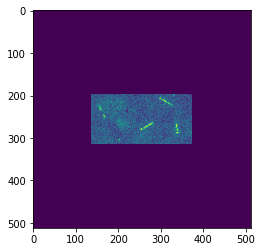

In [32]:
plt.imshow(preprocessing_results["molded_image"][:, :, 0])

# Load Model and Run Prediction

In [33]:
# Load Mask-RCNN model
with tf.gfile.FastGFile(str(tf_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')
    
# Prepare inputs
molded_images = [preprocessing_results["molded_image"]]
image_metas = [preprocessing_results["image_metadata"]]
anchors = [preprocessing_results["anchors"]]

with tf.Session() as sess:
    
    # Prepare inputs and outputs
    input_image_tensor = get_tensor(sess.graph, INPUT_NODE_IMAGE_NAME)
    input_image_metadat_tensor = get_tensor(sess.graph, INPUT_NODE_IMAGE_METADATA_NAME)
    input_anchor_tensor = get_tensor(sess.graph, INPUT_NODE_ANCHORS_NAME)
    
    input_data = {input_image_tensor: molded_images,
                  input_image_metadat_tensor: image_metas,
                  input_anchor_tensor: anchors}

    output_data = {node_name: get_tensor(sess.graph, f'output_{node_name}')
                   for node_name in OUTPUT_NODE_NAMES}
    
    # Run the prediction
    raw_results = sess.run(fetches=output_data, feed_dict=input_data)

# Do postprocessing

In [34]:
# Load preprocessing graph
with tf.gfile.FastGFile(str(postprocessing_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')

In [35]:
with tf.Session() as sess:
  
    # Declare inputs
    detections = get_tensor(sess.graph, "detections")
    mrcnn_mask = get_tensor(sess.graph, "mrcnn_mask")
    original_image_shape = get_tensor(sess.graph, "original_image_shape")
    image_shape = get_tensor(sess.graph, "image_shape")
    window = get_tensor(sess.graph, "window")
    
    feed_dict = {detections: raw_results["detections"],
                 mrcnn_mask: raw_results["mrcnn_mask"],
                 original_image_shape: list(original_images.shape[1:3]) + [1],
                 image_shape: IMAGE_SHAPE,
                 window: preprocessing_results["window"]}
    
    # Declare outputs   
    fetches = {"rois": get_tensor(sess.graph, "rois"),
               "class_ids": get_tensor(sess.graph, "class_ids"),
               "scores": get_tensor(sess.graph, "scores"),
               "masks": get_tensor(sess.graph, "masks")}
    
    postprocessing_results = sess.run(fetches, feed_dict=feed_dict)
    
postprocessing_results["rois"]

array([[ 64, 114,  87, 148],
       [ 46,  26,  57,  35],
       [ 23,  14,  40,  26],
       [  8, 160,  28, 192],
       [104,  63, 115,  70],
       [  0, 189,   8, 197],
       [ 67, 196,  92, 205],
       [104,  42, 112,  49],
       [  6, 158,  14, 166]], dtype=int32)

# Display result of detection

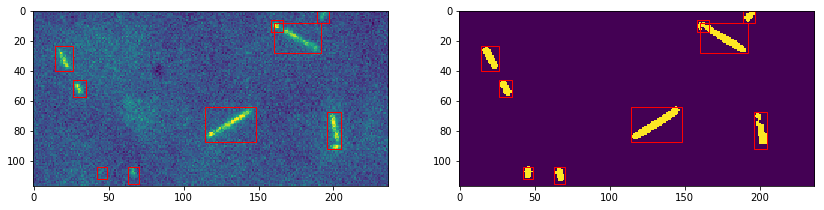

In [36]:
from matplotlib.patches import Rectangle

projected_masks = postprocessing_results['masks'].max(axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

ax1.imshow(original_image)
ax2.imshow(projected_masks)

for i, roi in enumerate(postprocessing_results["rois"]):
    y1, x1, y2, x2 = roi
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
    ax1.add_artist(rect)
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
    ax2.add_artist(rect)